<a href="https://colab.research.google.com/github/RudyMartin/dsai-2024/blob/main/dsai_cifar10_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CIFAR10 Version #3 with suggested changes

### Model Overview

#### Data Loading and Normalization:
- Uses `torchvision` to load CIFAR-10 dataset.
- Applies normalization to transform the images.

#### Model Architecture:
- A simple Convolutional Neural Network (CNN) with two convolutional layers followed by three fully connected layers.
- The network uses ReLU activations and max pooling.

#### Training:
- Uses `CrossEntropyLoss` and SGD with momentum for optimization.
- Training loop runs for 2 epochs, iterating over the dataset.

#### Evaluation:
- Model accuracy is computed on the test dataset.
- The script prints the accuracy for each class and the overall accuracy.

### Suggestions for Improvement

#### Increase Model Complexity:
- **More Convolutional Layers**: Add more convolutional layers to capture more complex patterns.
- **Batch Normalization**: Add batch normalization layers to improve training stability and speed.
- **Dropout**: Add dropout layers to reduce overfitting.

#### Data Augmentation:
- Apply data augmentation techniques (e.g., random horizontal flip, random crop) to increase the diversity of


### Key Changes in this version

#### Model Architecture:
- Added an additional convolutional layer.
- Included batch normalization and dropout layers.

#### Data Augmentation:
- Added random cropping and horizontal flipping to the training data.

#### Optimizer:
- Switched to the Adam optimizer for better performance.

#### Learning Rate Scheduler:
- Added a learning rate scheduler to adjust the learning rate during training.

#### Training Epochs:
- Increased the number of training epochs to 50.

#### Additional Validation Metrics:
- Output specific and aggregate metrics to csv for added analysis.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Data augmentation and normalization for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# Just normalization for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class ImprovedNet(nn.Module):
    def __init__(self):
        super(ImprovedNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

net = ImprovedNet()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Training loop
for epoch in range(5):  # Increase number of epochs to 50 , demo using 5
    running_loss = 0.0
    net.train()  # Set the model to training mode
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:  # Print every 200 mini-batches
            print(f'[Epoch {epoch + 1}, Batch {i + 1}] loss: {running_loss / 200:.3f}')
            running_loss = 0.0
    scheduler.step()

print('Finished Training')

# Save the trained model
PATH = './improved_cifar_net.pth'
torch.save(net.state_dict(), PATH)

# Testing loop
correct = 0
total = 0
net.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

# Accuracy for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1

for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')


Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch 200] loss: 1.848
[Epoch 2, Batch 200] loss: 1.396
[Epoch 3, Batch 200] loss: 1.219
[Epoch 4, Batch 200] loss: 1.102
[Epoch 5, Batch 200] loss: 1.025
Finished Training
Accuracy of the network on the 10000 test images: 70 %
Accuracy for class: plane is 75.2 %
Accuracy for class: car   is 85.3 %
Accuracy for class: bird  is 75.6 %
Accuracy for class: cat   is 40.1 %
Accuracy for class: deer  is 56.9 %
Accuracy for class: dog   is 60.2 %
Accuracy for class: frog  is 72.5 %
Accuracy for class: horse is 79.2 %
Accuracy for class: ship  is 79.1 %
Accuracy for class: truck is 80.3 %


Visualization

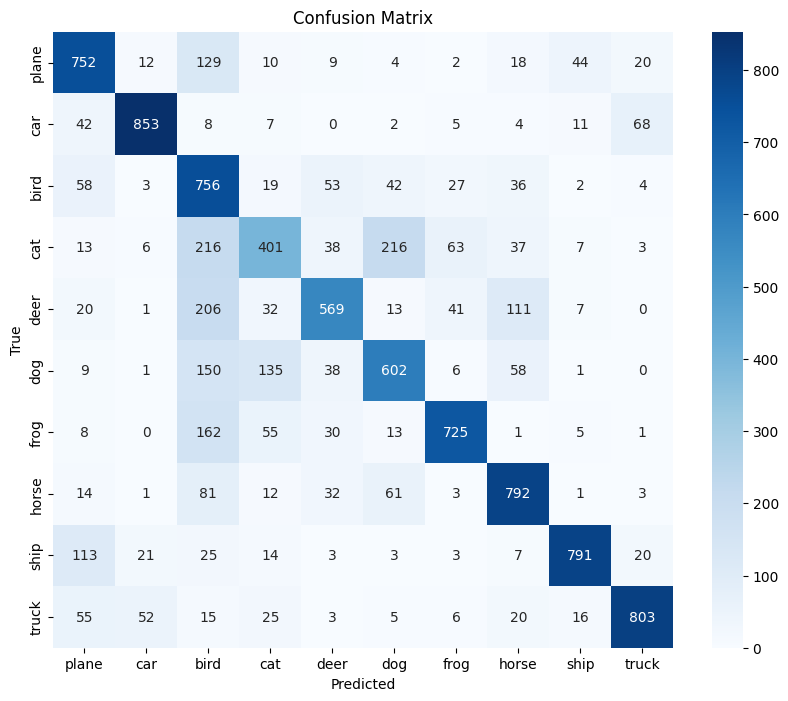

In [2]:
# Assuming the rest of your code has executed and you have your predictions and true labels
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming `net` is your trained model and `testloader` is your DataLoader for the test dataset
# Make sure your model is in evaluation mode
net.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

# Compute the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

Validation Results

In [3]:
# Assuming the rest of your code has executed and you have your predictions and true labels
# import matplotlib.pyplot as plt
# import numpy as np
# import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, balanced_accuracy_score, matthews_corrcoef, hamming_loss, jaccard_score, cohen_kappa_score, classification_report
import pandas as pd
# import torch

# Assuming `net` is your trained model and `testloader` is your DataLoader for the test dataset
# Make sure your model is in evaluation mode
# net.eval()

# all_preds = []
# all_labels = []

# with torch.no_grad():
#     for data in testloader:
#         images, labels = data
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         all_preds.extend(predicted.cpu().numpy())
#         all_labels.extend(labels.cpu().numpy())

# Convert all_preds and all_labels to numpy arrays
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Ensure `classes` is a list of strings representing the class names
#classes = [str(cls) for cls in classes]

# Compute the confusion matrix
# conf_matrix = confusion_matrix(all_labels, all_preds)

# Initialize the metrics dictionary
metrics = {
    'Class': [],
    'TP': [],
    'FN': [],
    'FP': [],
    'TN': [],
    'Recall': [],
    'Precision': [],
    'Accuracy': [],
    'F1 Score': [],
    'Specificity': [],
    'MCC': [],
    'Jaccard Index': []
}

# Calculate metrics for each class
for i, class_label in enumerate(classes):
    TP = conf_matrix[i, i]
    FN = conf_matrix[i, :].sum() - TP
    FP = conf_matrix[:, i].sum() - TP
    TN = conf_matrix.sum() - (TP + FN + FP)

    recall = TP / (TP + FN) if TP + FN != 0 else 0
    precision = TP / (TP + FP) if TP + FP != 0 else 0
    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN != 0 else 0
    f1 = f1_score(all_labels, all_preds, labels=[i], average=None)[0]
    specificity = TN / (TN + FP) if TN + FP != 0 else 0
    mcc = matthews_corrcoef(all_labels, all_preds)
    jaccard = jaccard_score(all_labels, all_preds, labels=[i], average=None)[0]

    metrics['Class'].append(class_label)
    metrics['TP'].append(TP)
    metrics['FN'].append(FN)
    metrics['FP'].append(FP)
    metrics['TN'].append(TN)
    metrics['Recall'].append(recall)
    metrics['Precision'].append(precision)
    metrics['Accuracy'].append(accuracy)
    metrics['F1 Score'].append(f1)
    metrics['Specificity'].append(specificity)
    metrics['MCC'].append(mcc)
    metrics['Jaccard Index'].append(jaccard)

# Convert metrics dictionary to DataFrame
df_metrics = pd.DataFrame(metrics)

# Show the DataFrame with all metrics
print(df_metrics)

# Save the DataFrame to a CSV file
df_metrics.to_csv('df_metrics_20240610.csv', index=False)

   Class   TP   FN   FP    TN  Recall  Precision  Accuracy  F1 Score  \
0  plane  752  248  332  8668   0.752   0.693727    0.9420  0.721689   
1    car  853  147   97  8903   0.853   0.897895    0.9756  0.874872   
2   bird  756  244  992  8008   0.756   0.432494    0.8764  0.550218   
3    cat  401  599  309  8691   0.401   0.564789    0.9092  0.469006   
4   deer  569  431  206  8794   0.569   0.734194    0.9363  0.641127   
5    dog  602  398  359  8641   0.602   0.626431    0.9243  0.613972   
6   frog  725  275  156  8844   0.725   0.822928    0.9569  0.770867   
7  horse  792  208  292  8708   0.792   0.730627    0.9500  0.760077   
8   ship  791  209   94  8906   0.791   0.893785    0.9697  0.839257   
9  truck  803  197  119  8881   0.803   0.870933    0.9684  0.835588   

   Specificity       MCC  Jaccard Index  
0     0.963111  0.674356       0.564565  
1     0.989222  0.674356       0.777575  
2     0.889778  0.674356       0.379518  
3     0.965667  0.674356       0.306341

Aggregate Metrics

Overall Accuracy: 0.7044
Balanced Accuracy: 0.7044
Precision (Macro): 0.7268
Recall (Macro): 0.7044
F1 Score (Macro): 0.7077
ROC-AUC Score (OvR): 0.8358

Classification Report:
               precision    recall  f1-score   support

       plane       0.69      0.75      0.72      1000
         car       0.90      0.85      0.87      1000
        bird       0.43      0.76      0.55      1000
         cat       0.56      0.40      0.47      1000
        deer       0.73      0.57      0.64      1000
         dog       0.63      0.60      0.61      1000
        frog       0.82      0.72      0.77      1000
       horse       0.73      0.79      0.76      1000
        ship       0.89      0.79      0.84      1000
       truck       0.87      0.80      0.84      1000

    accuracy                           0.70     10000
   macro avg       0.73      0.70      0.71     10000
weighted avg       0.73      0.70      0.71     10000



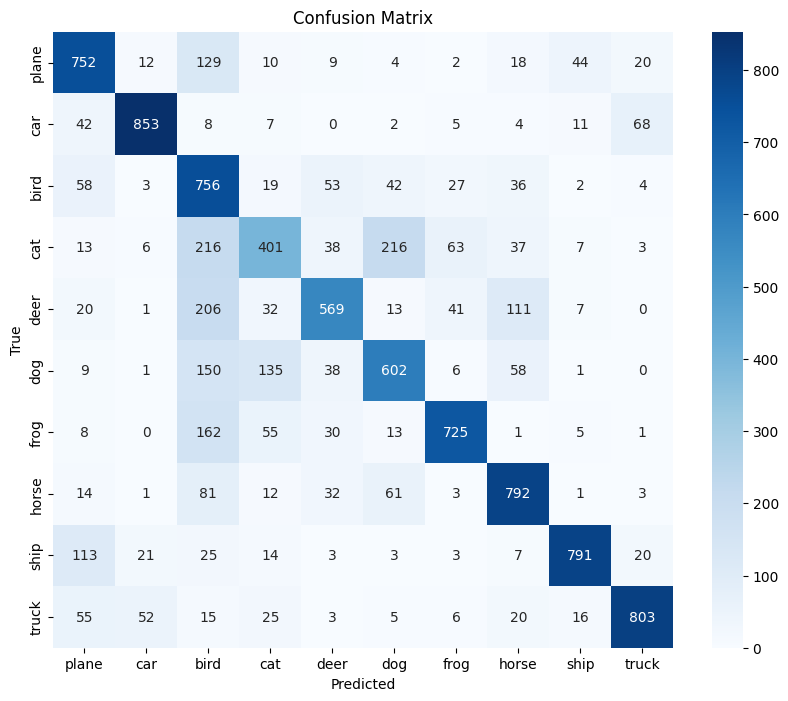

In [5]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import label_binarize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Convert all_preds and all_labels to numpy arrays if they are not already
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Binarize the labels for ROC-AUC calculation
all_labels_binarized = label_binarize(all_labels, classes=np.unique(all_labels))
all_preds_binarized = label_binarize(all_preds, classes=np.unique(all_preds))

# Compute overall metrics
overall_accuracy = accuracy_score(all_labels, all_preds)
balanced_accuracy = balanced_accuracy_score(all_labels, all_preds)
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro = recall_score(all_labels, all_preds, average='macro')
f1_macro = f1_score(all_labels, all_preds, average='macro')

# Compute ROC-AUC Score (one-vs-rest approach for multi-class)
roc_auc_ovr = roc_auc_score(all_labels_binarized, all_preds_binarized, multi_class='ovr')

# Generate classification report
class_report = classification_report(all_labels, all_preds, target_names=classes)

# Print aggregate metrics
print(f'Overall Accuracy: {overall_accuracy:.4f}')
print(f'Balanced Accuracy: {balanced_accuracy:.4f}')
print(f'Precision (Macro): {precision_macro:.4f}')
print(f'Recall (Macro): {recall_macro:.4f}')
print(f'F1 Score (Macro): {f1_macro:.4f}')
print(f'ROC-AUC Score (OvR): {roc_auc_ovr:.4f}')
print('\nClassification Report:\n', class_report)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Heatmap with Percentage Values**

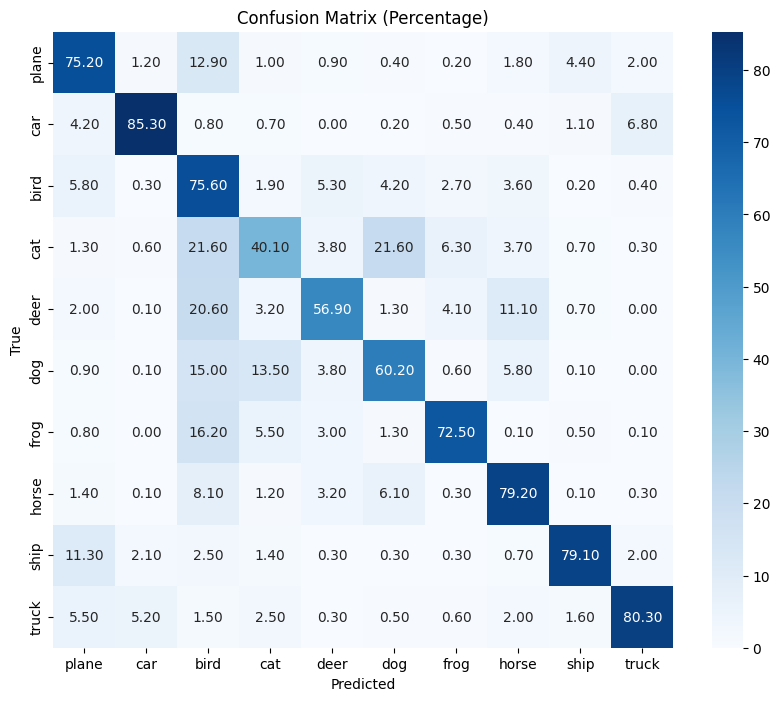

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming all_labels and all_preds are already defined
conf_matrix = confusion_matrix(all_labels, all_preds)
conf_matrix_percentage = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percentage, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Percentage)')
plt.show()

**Normalized Confusion Matrix**

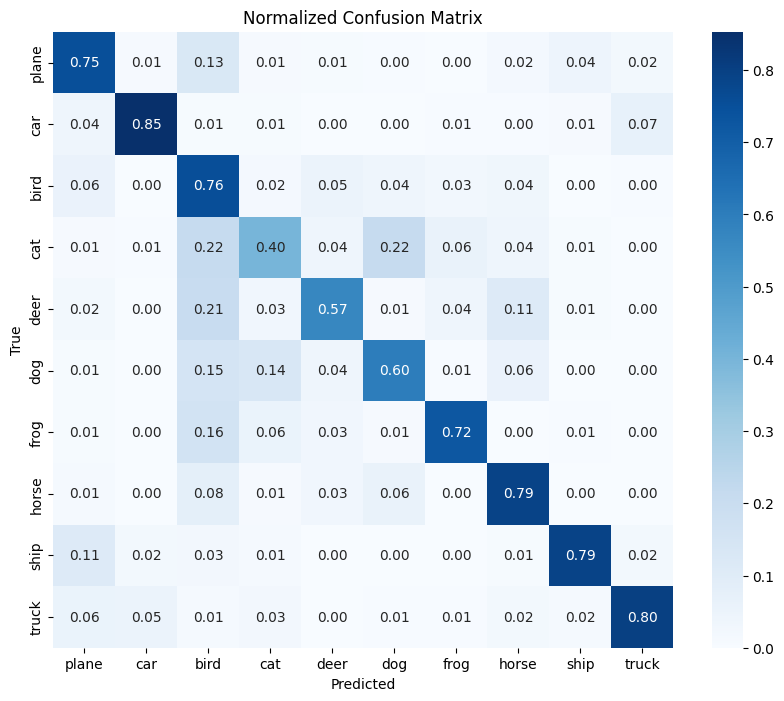

In [7]:
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

**Confusion Matrix with Annotations**

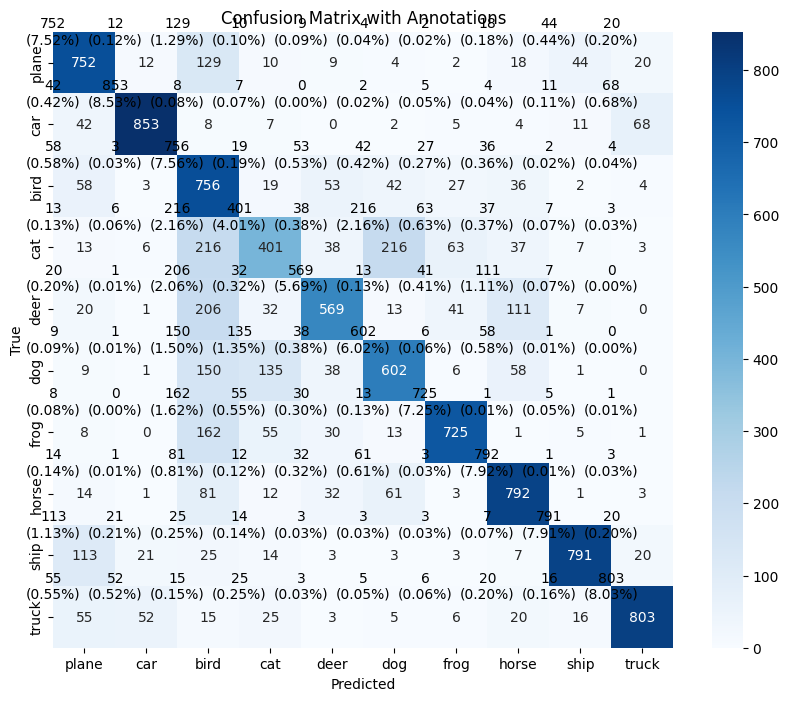

In [9]:
def plot_confusion_matrix_with_annotations(conf_matrix, classes):
    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes, ax=ax)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            text = ax.text(j, i, f"{conf_matrix[i, j]}\n({conf_matrix[i, j] / conf_matrix.sum() * 100:.2f}%)",
                           ha="center", va="center", color="black")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix with Annotations')
    plt.show()

plot_confusion_matrix_with_annotations(conf_matrix, classes)


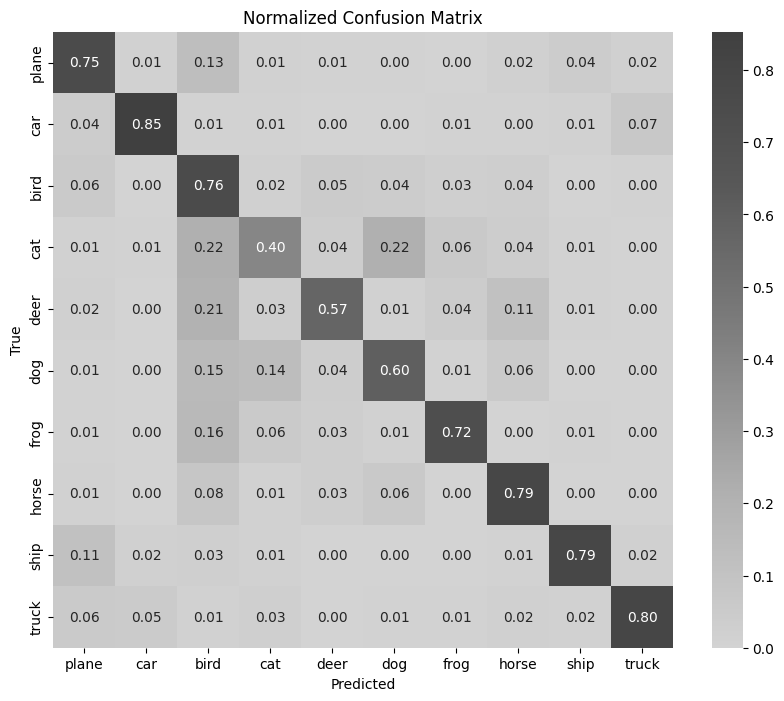

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assuming conf_matrix and classes are already defined
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define a custom colormap with five phases
# colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']  # red to green spectrum
# Define a custom colormap with five phases
# colors = ['#0000ff', '#4b0082', '#9400d3', '#8a2be2', '#dda0dd']  # Blue to purple spectrum
# colors = ['#dda0dd', '#8a2be2', '#9400d3', '#4b0082', '#0000ff']  # purple to Blue  spectrum
colors = ['#d3d3d3', '#b0b0b0', '#808080', '#585858', '#404040']  # Light gray to medium gray spectrum

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

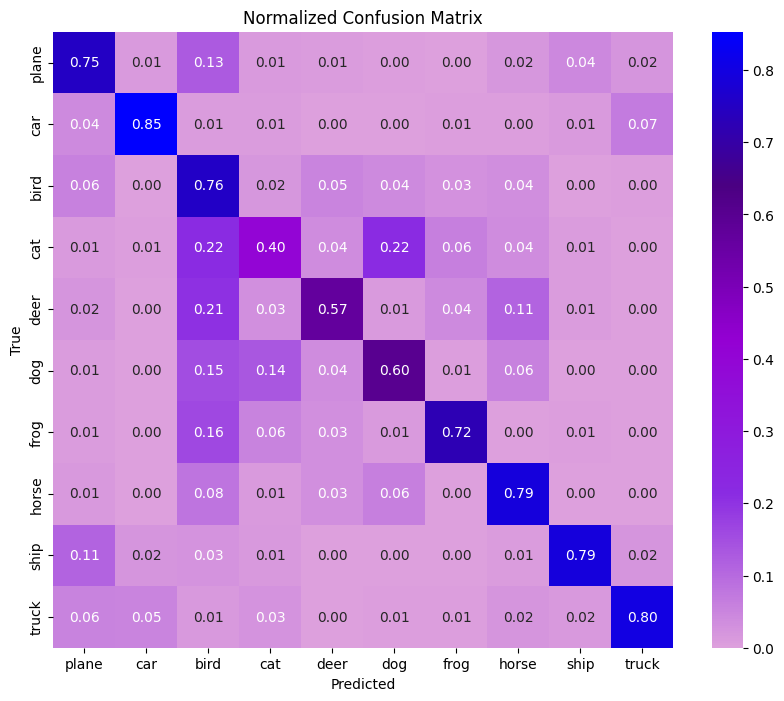

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Assuming conf_matrix and classes are already defined
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Define a custom colormap with five phases
# colors = ['#d73027', '#fc8d59', '#fee08b', '#d9ef8b', '#1a9850']  # red to green spectrum
# Define a custom colormap with five phases
# colors = ['#0000ff', '#4b0082', '#9400d3', '#8a2be2', '#dda0dd']  # Blue to purple spectrum
colors = ['#dda0dd', '#8a2be2', '#9400d3', '#4b0082', '#0000ff']  # purple to Blue  spectrum
#colors = ['#d3d3d3', '#b0b0b0', '#808080', '#585858', '#404040']  # Light gray to medium gray spectrum

cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=256)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap=cmap, xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()